In [1]:
import pandas as pd
import glob 
import numpy as np
import os
import trajectory_planning_helpers as tph
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.collections import LineCollection
from f1tenth_sim.utils.MapData import MapData
from f1tenth_sim.utils.track_utils import RaceTrack, CentreLine


save_path = '../Data/BenchmarkArticle/'
if not os.path.exists(save_path):
    os.makedirs(save_path)

In [2]:

summary_df = pd.read_csv("../Logs/Summary.csv")

planner = "GlobalPlanPP"
friction_vals = np.linspace(0.55, 1, 10)
simulator_timestep_list = [1, 2, 5, 10, 12, 14]

map_list = ["aut", "esp", "gbr", "mco"]

summary_df = summary_df[summary_df["Vehicle"] == planner]
test_ids = summary_df["TestID"].str.split("_", expand=True)
summary_df["mu"] = test_ids[0].str[2:].astype(float) / 100
timestep_series = test_ids[1].str[5:]
timestep_series.dropna(inplace=True)
summary_df["simulator_timestep"] = timestep_series.astype(int) 
# summary_df["mu"] = (summary_df["TestID"].split("_")[0][2:] / 100).astype(float)
# summary_df["simulator_timestep"] = (summary_df["TestID"].split("_")[1][5:] / 100).astype(int)
# add in frequency here.

n_laps = 5

print(summary_df.sample(n=10))
# print(summary_df.head())


          Vehicle         TestID MapName  AvgProgress  AvgTime  StdTime  \
413  GlobalPlanPP   mu75_steps14     mco       0.0764      NaN      NaN   
196  GlobalPlanPP    mu65_steps8     esp       0.9962   40.768   0.1659   
227  GlobalPlanPP    mu80_steps8     esp       0.9962   38.192   0.1842   
94   GlobalPlanPP    mu65_steps6     aut       0.9983   19.356   0.2269   
96   GlobalPlanPP           mu70     aut       0.9966   18.664   0.1992   
263  GlobalPlanPP  mu100_steps20     gbr       0.0114      NaN      NaN   
158  GlobalPlanPP  mu100_steps10     esp       0.1809      NaN      NaN   
306  GlobalPlanPP    mu70_steps5     gbr       0.9956   33.970   0.2361   
427  GlobalPlanPP    mu80_steps5     mco       0.9959   29.470   0.0908   
324  GlobalPlanPP   mu80_steps20     gbr       0.0134      NaN      NaN   

     CompletionRate                   VehicleID    mu  simulator_timestep  
413             0.0   GlobalPlanPP_mu75_steps14  0.75                14.0  
196             1.0   

In [3]:

test_ids = summary_df["TestID"].unique()
# print(test_ids)

lap_dfs = []
for i, test_id in enumerate(test_ids):
    for m, map_name in enumerate(map_list):
        for lap_n in range(n_laps):
            data = np.load(f"../Logs/{planner}/RawData_{test_id}/SimLog_{map_name}_{lap_n}.npy")[1:, :] #remove first repeated entry
            df = pd.DataFrame(data, columns=["x", "y", "steer", "speed", "yaw", "yaw_rate", "slip", "steer_a", "speed_a", "progress"])
            df.steer_a = df.steer_a * 180 / np.pi
            df.yaw = df.yaw * 180 / np.pi
            df.slip = df.slip.abs() * 180 / np.pi

            el_lengths = np.linalg.norm(np.diff(data[:, :2], axis=0), axis=1)
            s_old = np.insert(np.cumsum(el_lengths), 0, 0)
            s_interp = np.linspace(0, np.sum(el_lengths), 1000)
            x_interp = np.interp(s_interp, s_old, data[:, 0])
            y_interp = np.interp(s_interp, s_old, data[:, 1])
            interp_path = np.stack([x_interp, y_interp], axis=1)
            el_lengths = np.linalg.norm(np.diff(interp_path, axis=0), axis=1)
            psi, kappa = tph.calc_head_curv_num.calc_head_curv_num(interp_path, el_lengths, False)
            kappa_original_s = np.interp(s_old, s_interp, kappa)
            df["curvature"] = np.abs(kappa_original_s) * 180 / np.pi
            df["d_steer"] = df.steer_a.diff().abs() 
            df["lap_n"] = lap_n
            df["map_name"] = map_name
            df["test_id"] = test_id
            df["mu"] = summary_df[summary_df["TestID"] == test_id]["mu"].values[0]
            df["simulator_timestep"] = summary_df[summary_df["TestID"] == test_id]["simulator_timestep"].values[0]

            try:
                data = np.load(f"../Logs/{planner}/RawData_{test_id}/TrackingAccuracy_{map_name}_{lap_n}.npy")[1:, :] #remove first repeated entry
                df["ct_error"] = np.abs(data[:, 1])
                df["speed_error"] = np.abs(data[:, 4])
                df["raceline_speed"] = np.abs(data[:, 5])
            except: pass
            lap_dfs.append(df)


lap_df = pd.concat(lap_dfs)
lap_df.dropna(inplace=True)
lap_df.loc[lap_df["progress"] < 0.05, "speed_error"] = 0
lap_df.loc[lap_df["progress"] < 0.02, "curvature"] = 0
print(lap_df.head())


          x    y  steer    speed  yaw  yaw_rate  slip  steer_a  speed_a  \
1  0.000000  0.0    0.0  0.03804  0.0       0.0   0.0      0.0      4.0   
2  0.000380  0.0    0.0  0.13314  0.0       0.0   0.0      0.0      4.0   
3  0.001712  0.0    0.0  0.22824  0.0       0.0   0.0      0.0      4.0   
4  0.003994  0.0    0.0  0.32334  0.0       0.0   0.0      0.0      4.0   
5  0.007228  0.0    0.0  0.41844  0.0       0.0   0.0      0.0      4.0   

   progress  curvature  d_steer  lap_n map_name       test_id   mu  \
1       0.0        0.0      0.0      0      aut  mu100_steps1  1.0   
2       0.0        0.0      0.0      0      aut  mu100_steps1  1.0   
3       0.0        0.0      0.0      0      aut  mu100_steps1  1.0   
4       0.0        0.0      0.0      0      aut  mu100_steps1  1.0   
5       0.0        0.0      0.0      0      aut  mu100_steps1  1.0   

   simulator_timestep  ct_error  speed_error  raceline_speed  
1                 1.0  0.520252          0.0             8.0  
2 

[ 1. 10. 12.  2.  4.  5.  6.  8.]
i: 0 - timestep: 1
i: 1 - timestep: 2
i: 2 - timestep: 4
i: 3 - timestep: 6
i: 4 - timestep: 10


/var/folders/nl/prw5ytm164qdzhwdvxnm_tdm0000gn/T/ipykernel_83013/3267502720.py:40: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


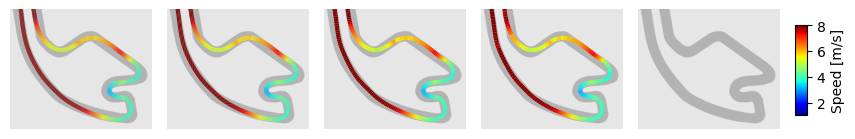

In [7]:
plot_map = "mco"
map_data = MapData(plot_map)
map_df = lap_df[lap_df["map_name"] == plot_map]
friction = 0.9
map_df = map_df[map_df["mu"] == friction]
lap_n = 1
map_df = map_df[map_df["lap_n"] == lap_n]

print(map_df.simulator_timestep.unique())

timesteps = [1, 2, 4, 6, 10]

fig, axs = plt.subplots(1, len(timesteps), figsize=(8, 2.5), sharex=True, sharey=True)
for i in range(len(timesteps)):
    print(f"i: {i} - timestep: {timesteps[i]}")
    plt.sca(axs[i])
    map_data.plot_map_img()

    df = map_df[map_df['simulator_timestep'] == timesteps[i]]
    # print(df.head(n=1))

    xs, ys = map_data.xy2rc(df.x, df.y)
    pts = np.array([xs, ys]).T.reshape(-1, 1, 2)
    segments = np.concatenate([pts[:-1], pts[1:]], axis=1)
    norm = plt.Normalize(1, 8)
    lc = LineCollection(segments, cmap='jet', norm=norm)
    lc.set_array(df.speed.values)
    lc.set_linewidth(3)
    line = plt.gca().add_collection(lc)
    
    plt.axis('off')
    axs[i].set_aspect('equal')
    plt.xlim(600, 1110)
    plt.ylim(70, 500)
    # plt.title(neat_planner_names[i])

ax = plt.gca()
cax = fig.add_axes([ax.get_position().x1+0.1, ax.get_position().y0, 0.015, ax.get_position().height])
plt.colorbar(line, cax=cax, label="Speed [m/s]", ticks=[2, 4, 6, 8])
plt.tight_layout()


[1.]
i: 0 - Mu: 0.55
i: 1 - Mu: 0.7
i: 2 - Mu: 0.85
i: 3 - Mu: 0.95


/var/folders/nl/prw5ytm164qdzhwdvxnm_tdm0000gn/T/ipykernel_83013/3963314827.py:38: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


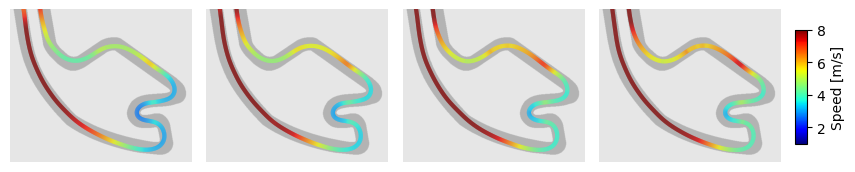

In [9]:
plot_map = "mco"
map_data = MapData(plot_map)
map_df = lap_df[lap_df["map_name"] == plot_map]
map_df = map_df[map_df["simulator_timestep"] == 1]
lap_n = 1
map_df = map_df[map_df["lap_n"] == lap_n]

print(map_df.simulator_timestep.unique())

mus = [0.55, 0.7, 0.85, 0.95]

fig, axs = plt.subplots(1, len(mus), figsize=(8, 2.5), sharex=True, sharey=True)
for i in range(len(mus)):
    print(f"i: {i} - Mu: {mus[i]}")
    plt.sca(axs[i])
    map_data.plot_map_img()

    df = map_df[map_df['mu'] == mus[i]]

    xs, ys = map_data.xy2rc(df.x, df.y)
    pts = np.array([xs, ys]).T.reshape(-1, 1, 2)
    segments = np.concatenate([pts[:-1], pts[1:]], axis=1)
    norm = plt.Normalize(1, 8)
    lc = LineCollection(segments, cmap='jet', norm=norm)
    lc.set_array(df.speed.values)
    lc.set_linewidth(3)
    line = plt.gca().add_collection(lc)
    
    plt.axis('off')
    axs[i].set_aspect('equal')
    plt.xlim(600, 1110)
    plt.ylim(70, 500)
    # plt.title(neat_planner_names[i])

ax = plt.gca()
cax = fig.add_axes([ax.get_position().x1+0.1, ax.get_position().y0, 0.015, ax.get_position().height])
plt.colorbar(line, cax=cax, label="Speed [m/s]", ticks=[2, 4, 6, 8])
plt.tight_layout()
